In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())


11.7
True


In [2]:
use_cuda=torch.cuda.is_available()
device=torch.device('cuda:0' if use_cuda else 'cpu')

In [ ]:
! pip install SentencePiece


In [ ]:
! pip install transformers


In [ ]:
! pip install pandas

In [ ]:
! pip install -U matplotlib

In [ ]:
! pip install wandb

In [20]:
! wandb login 0cf8d63ac20cff538d748e7412a8d60561ff1268

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\priya/.netrc


In [50]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams["figure.figsize"] = 16, 12
import wandb
import re
from collections import Counter

In [22]:
class QuotesDataset(Dataset):
    def __init__(self, quotes, tokenizer):
        self.quotes = quotes
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.quotes)

    def __getitem__(self, idx):
        text = self.quotes[idx]
        inputs = self.tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=1024)
        return torch.tensor(inputs)

In [94]:
full_dataset =pd.read_csv('../../../quotes_dataset.csv',low_memory=False)


In [95]:
print(full_dataset.shape)

(499709, 42)


In [96]:
for i in range(len(full_dataset)):
    # # check if the 'quotes' value is a string
    # if not isinstance(full_dataset.loc[i, 'quotes'], str):
    #     full_dataset = full_dataset.drop(i)
        
    # check if the 'tags' value is a string
    if not isinstance(full_dataset.loc[i, 'tags'], str):
        full_dataset = full_dataset.drop(i)

In [97]:
print(full_dataset.shape)

(499646, 42)


In [98]:
# Lowercase the text
# full_dataset['tags'] = full_dataset['tags'].apply(lambda x: x.lower())
tag_string = ','.join(full_dataset['tags'])
tag_list = [tag.strip() for tag in tag_string.split(',')] # all tags in this list
tag_counts = Counter(tag_list)


In [99]:
tag_df = pd.DataFrame({'tag': tag_counts.keys(), 'count': tag_counts.values()})
tag_df = tag_df.sort_values(by='count', ascending=False)
print(tag_df)

                                          tag  count
3                                        love  38805
2                                        life  35074
11                              inspirational  29080
28                                 philosophy  14939
81                                      humor  14081
...                                       ...    ...
80514                         cassie-giovanni      1
80513                      cassandra-giovanni      1
80512                      beautifully-flawed      1
80511   Sir Sultan Muhammad Shah Aga Khan III      1
150391                             Sacrifices      1

[150392 rows x 2 columns]


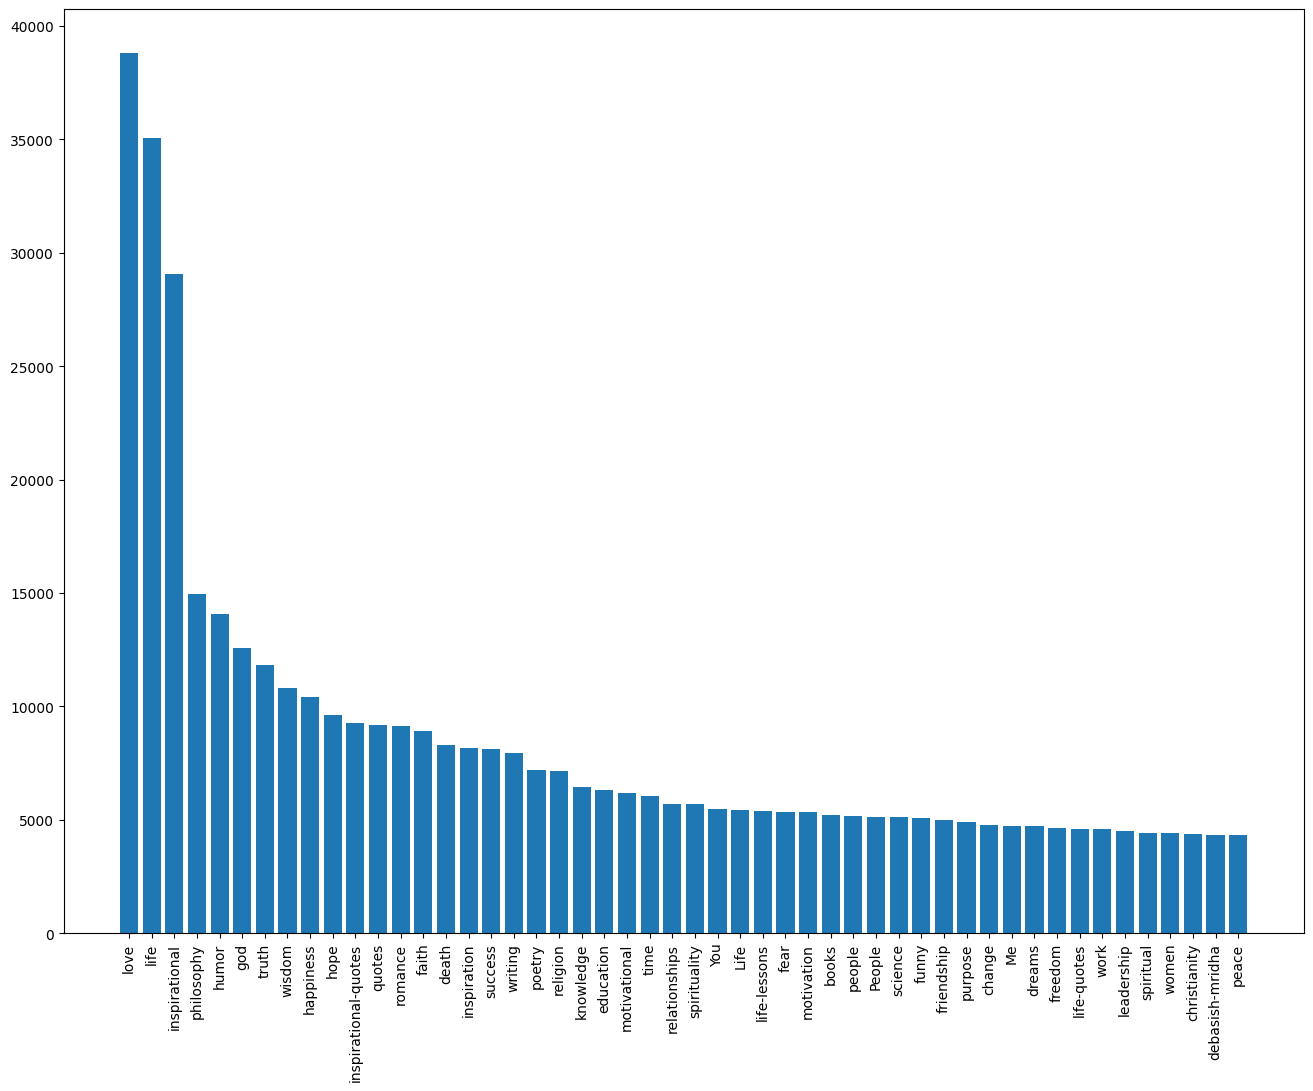

In [100]:
plt.bar(tag_df['tag'][:50], tag_df['count'][:50])
plt.xticks(rotation=90)
plt.show()

In [101]:
#Data preprocessing
# Remove new line
full_dataset['quotes'] = full_dataset['quotes'].apply(lambda x: re.sub(r'\n+', ' ', x))

# Lowercase the text
full_dataset['quotes'] = full_dataset['quotes'].apply(lambda x: x.lower())

In [102]:
print(full_dataset.shape)

(499646, 42)


In [24]:
quotes = full_dataset['quotes']
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# add padding token to tokenizer vocabulary
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    print('Added padding token to tokenizer')


tokenizer.pad_token = '[PAD]'
dataset = QuotesDataset(quotes, tokenizer)

Using pad_token, but it is not set yet.


Added padding token to tokenizer


In [32]:
batch_size=1
num_epochs=10
lr=2e-5

In [33]:
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device=device)
optimizer = AdamW(model.parameters(), lr=lr)

c:\Users\priya\anaconda3\envs\my_env_2\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [34]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [35]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [36]:
wandb.init(
    # set the wandb project where this run will be logged
    project="quotes-generator-project-1",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "GPT-2",
    "dataset": "Quotes Dataset",
    "epochs": num_epochs,
    }
)
#Need to add batch size, optimization algorithm, dropout rate, gpt-2 models

Training Loss,██▇▆█▆█▆▆▆▇▇█▆▇▇▅▄▆▆▅▄▅▃▄▅▅▃▄▇▂▅▁▅▇▁▂▃▁▄
Validation Loss,▃▄▂▅▁▂▃▃▃▃▄▁▃▂▃▃▄▄▂▃▄▂▄▃▂▄▃▄▂▃▄▄▅▄▆█▅▆▄▃
Training Loss,1.06438
Validation Loss,4.0871


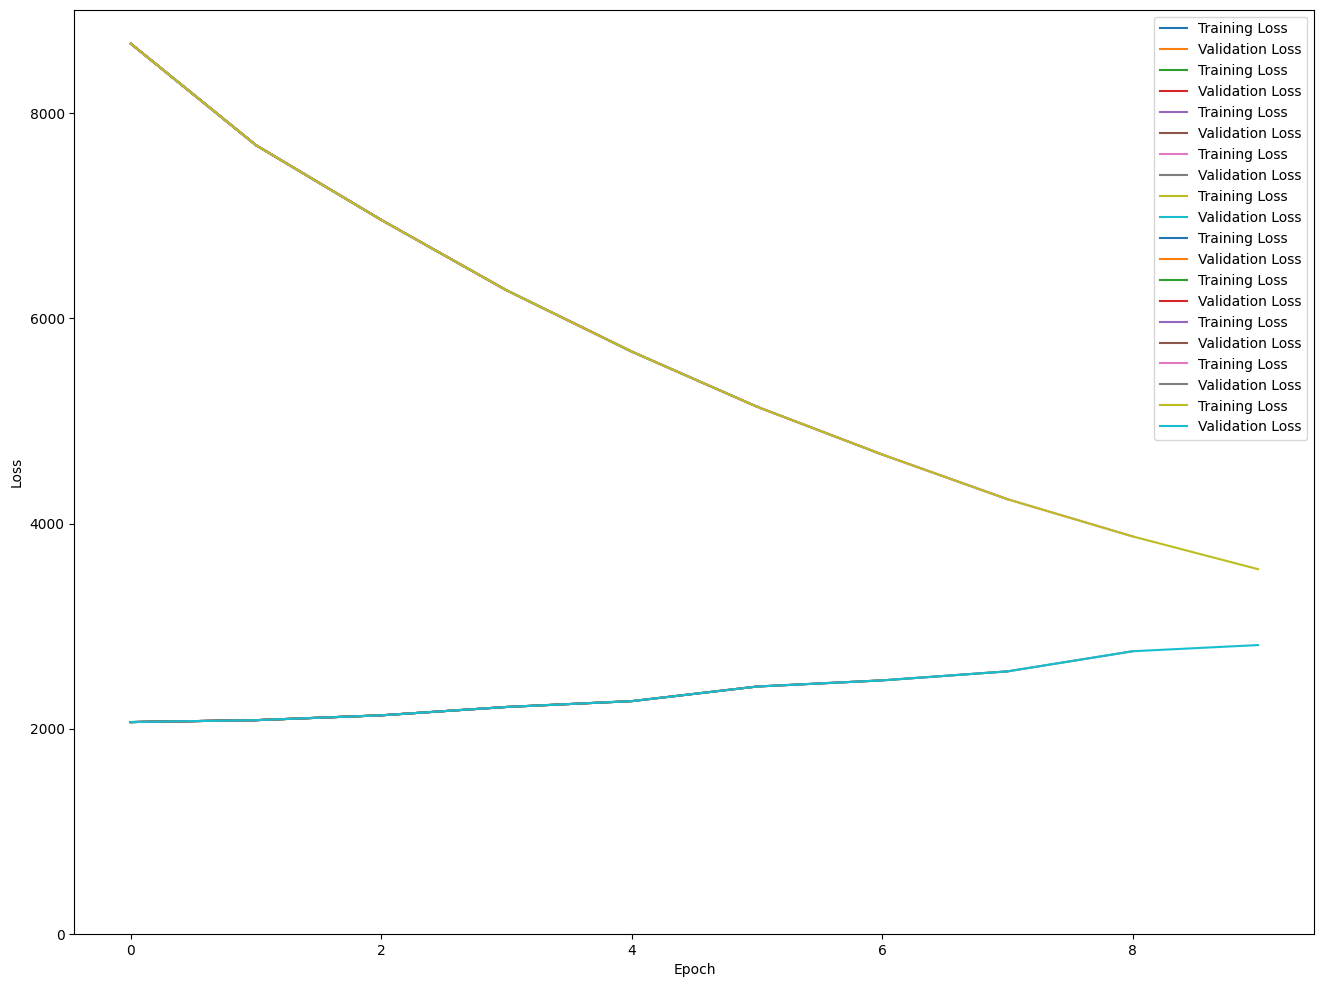

In [37]:
all_training_loss=[]
all_valid_loss=[]
for epoch in range(num_epochs):
    tr_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for batch in train_dataloader:
        # Pad each sequence to the maximum length in the batch
        batch = pad_sequence(batch, batch_first=True, padding_value=tokenizer.pad_token_id)
        batch = batch.to(model.device)
        outputs = model(input_ids=batch, labels=batch)
        
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        tr_epoch_loss += loss.item()
        optimizer.step()
        # log metrics to wandb
        wandb.log({"Training Loss": loss})
    all_training_loss.append(tr_epoch_loss)

    model.eval()	
    for batch in val_dataloader:	
        # Pad each sequence to the maximum length in the batch	
        batch = pad_sequence(batch, batch_first=True, padding_value=tokenizer.pad_token_id)	
        batch = batch.to(model.device)	
        outputs = model(input_ids=batch, labels=batch)	
        	
        loss = outputs.loss	
        val_epoch_loss += loss.item()	
    	# log metrics to wandb
        wandb.log({"Validation Loss": loss})
    all_valid_loss.append(val_epoch_loss)

    plt.plot(all_training_loss, label='Training Loss')
    plt.plot(all_valid_loss, label='Validation Loss')
    plt.ylim(bottom=0)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    # Save the model after each epoch
    torch.save(model.state_dict(), f'gpt2_finetuned_epoch_{epoch}.pt')

    
wandb.finish()

In [44]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the fine-tuned GPT-2 model and tokenizer
# Load the model checkpoint
model_path = "gpt2_finetuned_epoch_9.pt"
model_state_dict = torch.load(model_path, map_location=torch.device(device=device))

# Create a new model and load the state dict
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.load_state_dict(model_state_dict)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Generate new quotes
prompt = "Violence"
input_ids = tokenizer.encode(prompt, add_special_tokens=True, return_tensors='pt')
output = model.generate(input_ids=input_ids, max_length=20, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True)
generated_quotes = [tokenizer.decode(seq, clean_up_tokenization_spaces=True) for seq in output]

# Print the generated quotes
print(generated_quotes)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Violence is not the absence of logicbut logic examined and recalculatedheated and curved to fit']
